In [31]:
import geopandas as pd
import contextily as ctx # Used for contextual basemaps
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube # Used for rasterizing
import os
import shapely
import imageio
import numpy as np
from IPython.display import Image
plt.rcParams['figure.figsize'] = (20, 20)
os.listdir("input")

['lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip',
 'statsnzpopulation-by-meshblock-2013-census-FGDB.zip',
 'statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip',
 'statsnzregional-council-2021-clipped-generalised-FGDB.zip',
 'lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip']

First, read regional council bounds. This geometry will be used to clip NZ-wide datasets to just the region of interest, Auckland

epsg:2193
CPU times: user 1.86 s, sys: 891 ms, total: 2.76 s
Wall time: 1.69 s


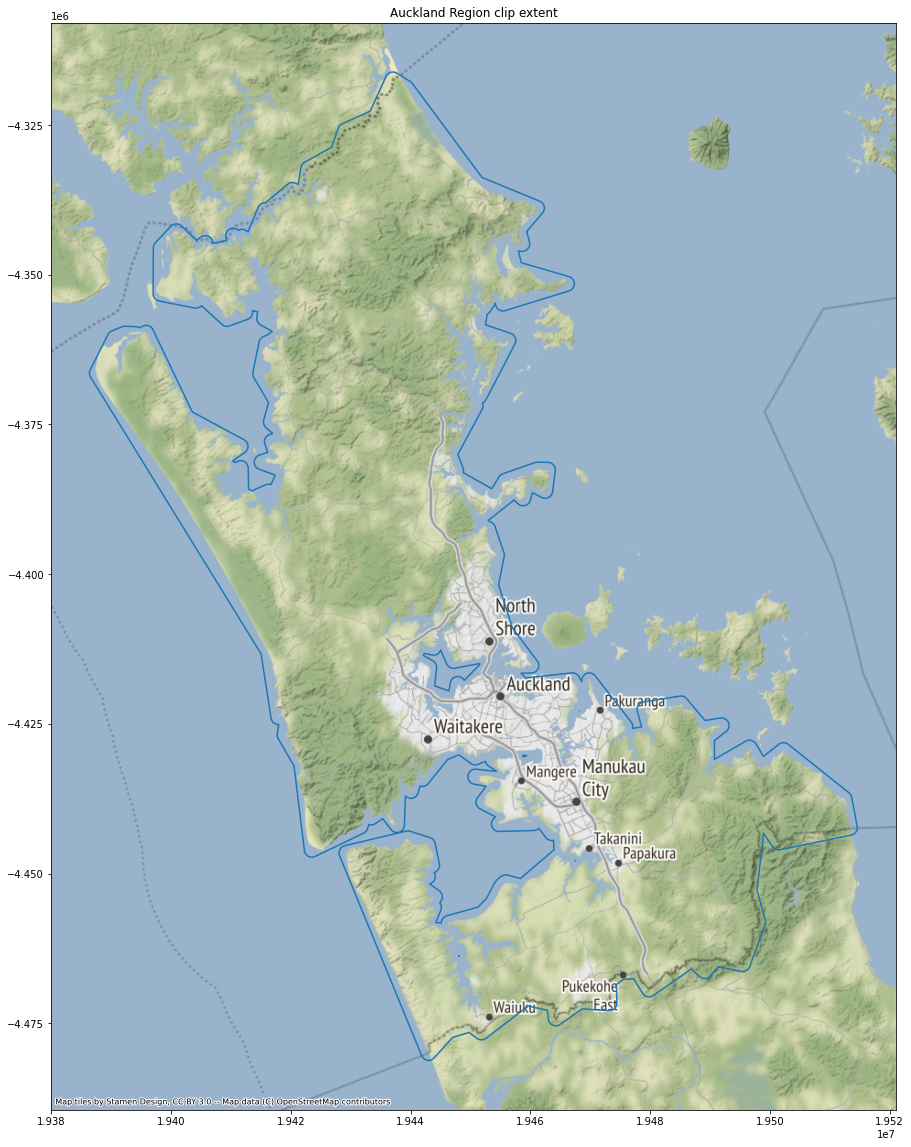

In [48]:
%%time
REGC = pd.read_file("input/statsnzregional-council-2021-clipped-generalised-FGDB.zip!regional-council-2021-clipped-generalised.gdb")
AKL = REGC[REGC.REGC2021_V1_00_NAME == "Auckland Region"].copy()
# Filter out islands
AKL["geometry"] = max(AKL.geometry.explode(), key=lambda a: a.area)
# Coordinate reference system (projection)
print(AKL.crs)
# Simplify geometry to speed up clip operations
AKL = AKL.simplify(1000).buffer(1000)
ax = AKL.to_crs(epsg=3857).boundary.plot()
ax.set_title("Auckland Region clip extent")
ctx.add_basemap(ax)

Load the LRIS Land Cover Database (downloaded in GDB format from https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/)

In [49]:
%%time
df = pd.read_file("zip://input/lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip!lcdb-v50-land-cover-database-version-50-mainland-new-zealand.gdb")

CPU times: user 1min 46s, sys: 1.78 s, total: 1min 48s
Wall time: 1min 48s


In [66]:
print(df.columns)
print(df.crs)
display(df.sample(5))

Index(['Name_2018', 'Name_2012', 'Name_2008', 'Name_2001', 'Name_1996',
       'Class_2018', 'Class_2012', 'Class_2008', 'Class_2001', 'Class_1996',
       'Wetland_18', 'Wetland_12', 'Wetland_08', 'Wetland_01', 'Wetland_96',
       'Onshore_18', 'Onshore_12', 'Onshore_08', 'Onshore_01', 'Onshore_96',
       'EditAuthor', 'EditDate', 'LCDB_UID', 'geometry',
       'Class_1996_simplified_code', 'Class_1996_simplified_name',
       'Class_2001_simplified_code', 'Class_2001_simplified_name',
       'Class_2008_simplified_code', 'Class_2008_simplified_name',
       'Class_2012_simplified_code', 'Class_2012_simplified_name',
       'Class_2018_simplified_code', 'Class_2018_simplified_name'],
      dtype='object')
epsg:2193


Name_2018                   Name_2012  \
475727           Indigenous Forest           Indigenous Forest   
464985  Built-up Area (settlement)  Built-up Area (settlement)   
47833   Built-up Area (settlement)  Built-up Area (settlement)   
405279               Exotic Forest               Exotic Forest   
347604               Exotic Forest               Exotic Forest   

                         Name_2008                        Name_2001  \
475727           Indigenous Forest                Indigenous Forest   
464985  Built-up Area (settlement)        Urban Parkland/Open Space   
47833   Built-up Area (settlement)  High Producing Exotic Grassland   
405279               Exotic Forest                    Exotic Forest   
347604               Exotic Forest                    Exotic Forest   

                              Name_1996  Class_2018  Class_2012  Class_2008  \
475727                Indigenous Forest          69          69          69   
464985        Urban Parkland/Open Space           1           1           1   
47833   High Producing Exotic Grassland           1           1           1   
405279                    Exotic Forest          71          71          71   
347604                    Exotic Forest          71          71          71   

        Class_2001  Class_1996  ... Class_1996_simplified_code  \
475727          69          69  ...                          2   
464985           2           2  ...                          1   
47833           40          40  ...                          4   
405279          71          71  ...                          2   
347604          71          71  ...                          2   

       Class_1996_simplified_name Class_2001_simplified_code  \
475727                 Vegetation                          2   
464985                      Urban                          1   
47833                       Other                          4   
405279                 Vegetation                          2   
347604                 Vegetation                          2   

       Class_2001_simplified_name Class_2008_simplified_code  \
475727                 Vegetation                          2   
464985                      Urban                          1   
47833                       Other                          1   
405279                 Vegetation                          2   
347604                 Vegetation                          2   

       Class_2008_simplified_name Class_2012_simplified_code  \
475727                 Vegetation                          2   
464985                      Urban                          1   
47833                       Urban                          1   
405279                 Vegetation                          2   
347604                 Vegetation                          2   

       Class_2012_simplified_name Class_2018_simplified_code  \
475727                 Vegetation                          2   
464985                      Urban                          1   
47833                       Urban                          1   
405279                 Vegetation                          2   
347604                 Vegetation                          2   

       Class_2018_simplified_name  
475727                 Vegetation  
464985                      Urban  
47833                       Urban  
405279                 Vegetation  
347604                 Vegetation  

[5 rows x 34 columns]

In [52]:
%%time
df = pd.clip(df, AKL)

CPU times: user 46.2 s, sys: 39 ms, total: 46.3 s
Wall time: 46.3 s


In [67]:
df.sample(5)

Name_2018             Name_2012             Name_2008  \
479126              Mangrove              Mangrove              Mangrove   
330587  Manuka and/or Kanuka  Manuka and/or Kanuka  Manuka and/or Kanuka   
475769         Exotic Forest         Exotic Forest         Exotic Forest   
283120  Manuka and/or Kanuka  Manuka and/or Kanuka  Manuka and/or Kanuka   
317261  Manuka and/or Kanuka  Manuka and/or Kanuka  Manuka and/or Kanuka   

                   Name_2001                        Name_1996  Class_2018  \
479126              Mangrove                         Mangrove          70   
330587  Manuka and/or Kanuka             Manuka and/or Kanuka          52   
475769         Exotic Forest  High Producing Exotic Grassland          71   
283120  Manuka and/or Kanuka             Manuka and/or Kanuka          52   
317261  Manuka and/or Kanuka             Manuka and/or Kanuka          52   

        Class_2012  Class_2008  Class_2001  Class_1996  ...  \
479126          70          70          70          70  ...   
330587          52          52          52          52  ...   
475769          71          71          71          40  ...   
283120          52          52          52          52  ...   
317261          52          52          52          52  ...   

       Class_1996_simplified_code Class_1996_simplified_name  \
479126                          4                      Other   
330587                          4                      Other   
475769                          4                      Other   
283120                          4                      Other   
317261                          4                      Other   

       Class_2001_simplified_code Class_2001_simplified_name  \
479126                          4                      Other   
330587                          4                      Other   
475769                          2                 Vegetation   
283120                          4                      Other   
317261                          4                      Other   

       Class_2008_simplified_code Class_2008_simplified_name  \
479126                          4                      Other   
330587                          4                      Other   
475769                          2                 Vegetation   
283120                          4                      Other   
317261                          4                      Other   

       Class_2012_simplified_code Class_2012_simplified_name  \
479126                          4                      Other   
330587                          4                      Other   
475769                          2                 Vegetation   
283120                          4                      Other   
317261                          4                      Other   

       Class_2018_simplified_code Class_2018_simplified_name  
479126                          4                      Other  
330587                          4                      Other  
475769                          2                 Vegetation  
283120                          4                      Other  
317261                          4                      Other  

[5 rows x 34 columns]

In [54]:
df.Name_2018.value_counts()

Exotic Forest                                3981
Indigenous Forest                            3673
Manuka and/or Kanuka                         2282
Broadleaved Indigenous Hardwoods             1788
Built-up Area (settlement)                   1350
High Producing Exotic Grassland              1326
Mangrove                                     1151
Urban Parkland/Open Space                    1099
Estuarine Open Water                          441
Orchard, Vineyard or Other Perennial Crop     436
Short-rotation Cropland                       362
Lake or Pond                                  326
Herbaceous Saline Vegetation                  303
Low Producing Grassland                       291
Gorse and/or Broom                            287
Forest - Harvested                            266
Sand or Gravel                                252
Deciduous Hardwoods                           201
Surface Mine or Dump                          132
Mixed Exotic Shrubland                        120


These classes are far too detailed - simplify to just Urban, Vegetation, Water, Other

In [55]:
def simplify_classes(code):
    if code in [1, 2, 5]:
        return 1, "Urban"
    elif code in [68,69,71]:
        return 2, "Vegetation"
    elif code in [0,20,21,22,45,46]:
        return 3, "Water"
    else:
        return 4, "Other"

summary = []
years = [1996, 2001, 2008, 2012, 2018]
for year in years:
    print(year)
    class_year = f"Class_{year}"
    df[class_year + "_simplified_code"] = df[class_year].apply(lambda c: simplify_classes(c)[0])
    df[class_year + "_simplified_name"] = df[class_year].apply(lambda c: simplify_classes(c)[1])
    summary.append(df[class_year + "_simplified_name"].value_counts())

1996
2001
2008
2012
2018


<AxesSubplot:>

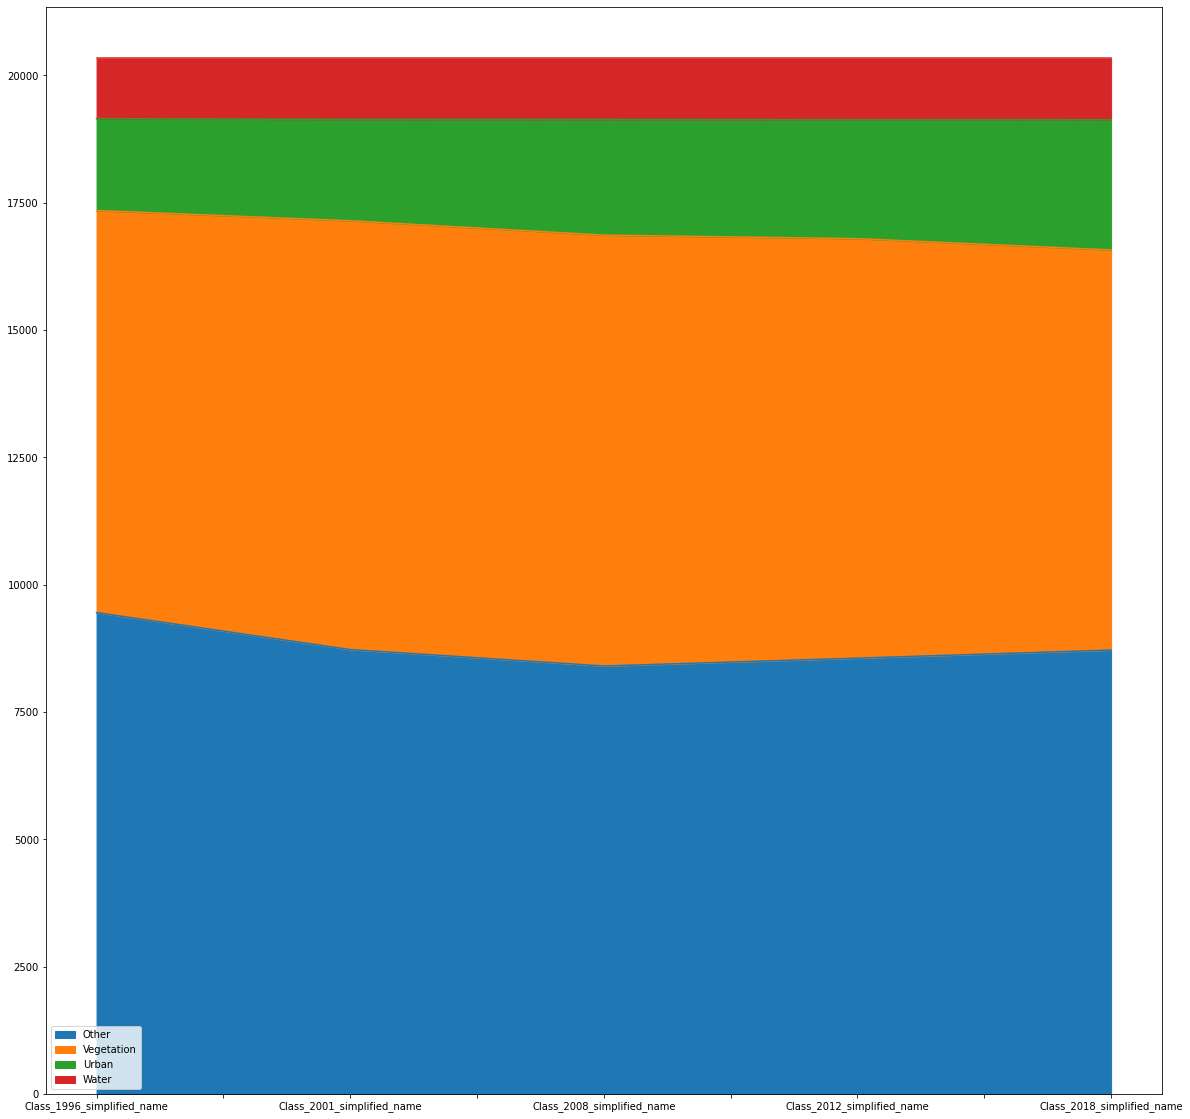

In [56]:
pd.GeoDataFrame(summary).plot.area()

In [57]:
%%capture
# %%capture suppresses output
ims = []
years = [1996, 2001, 2008, 2012, 2018]
for year in years:
    ax = df.plot(column=f'Class_{year}_simplified_name', legend=True)
    ax.set_title(year)
    ax.figure.tight_layout()
    canvas = ax.figure.canvas
    canvas.draw() # draw the canvas, cache the renderer
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (3,))
    ims.append(image)

imageio.mimsave("land_use.gif", ims, fps=1)

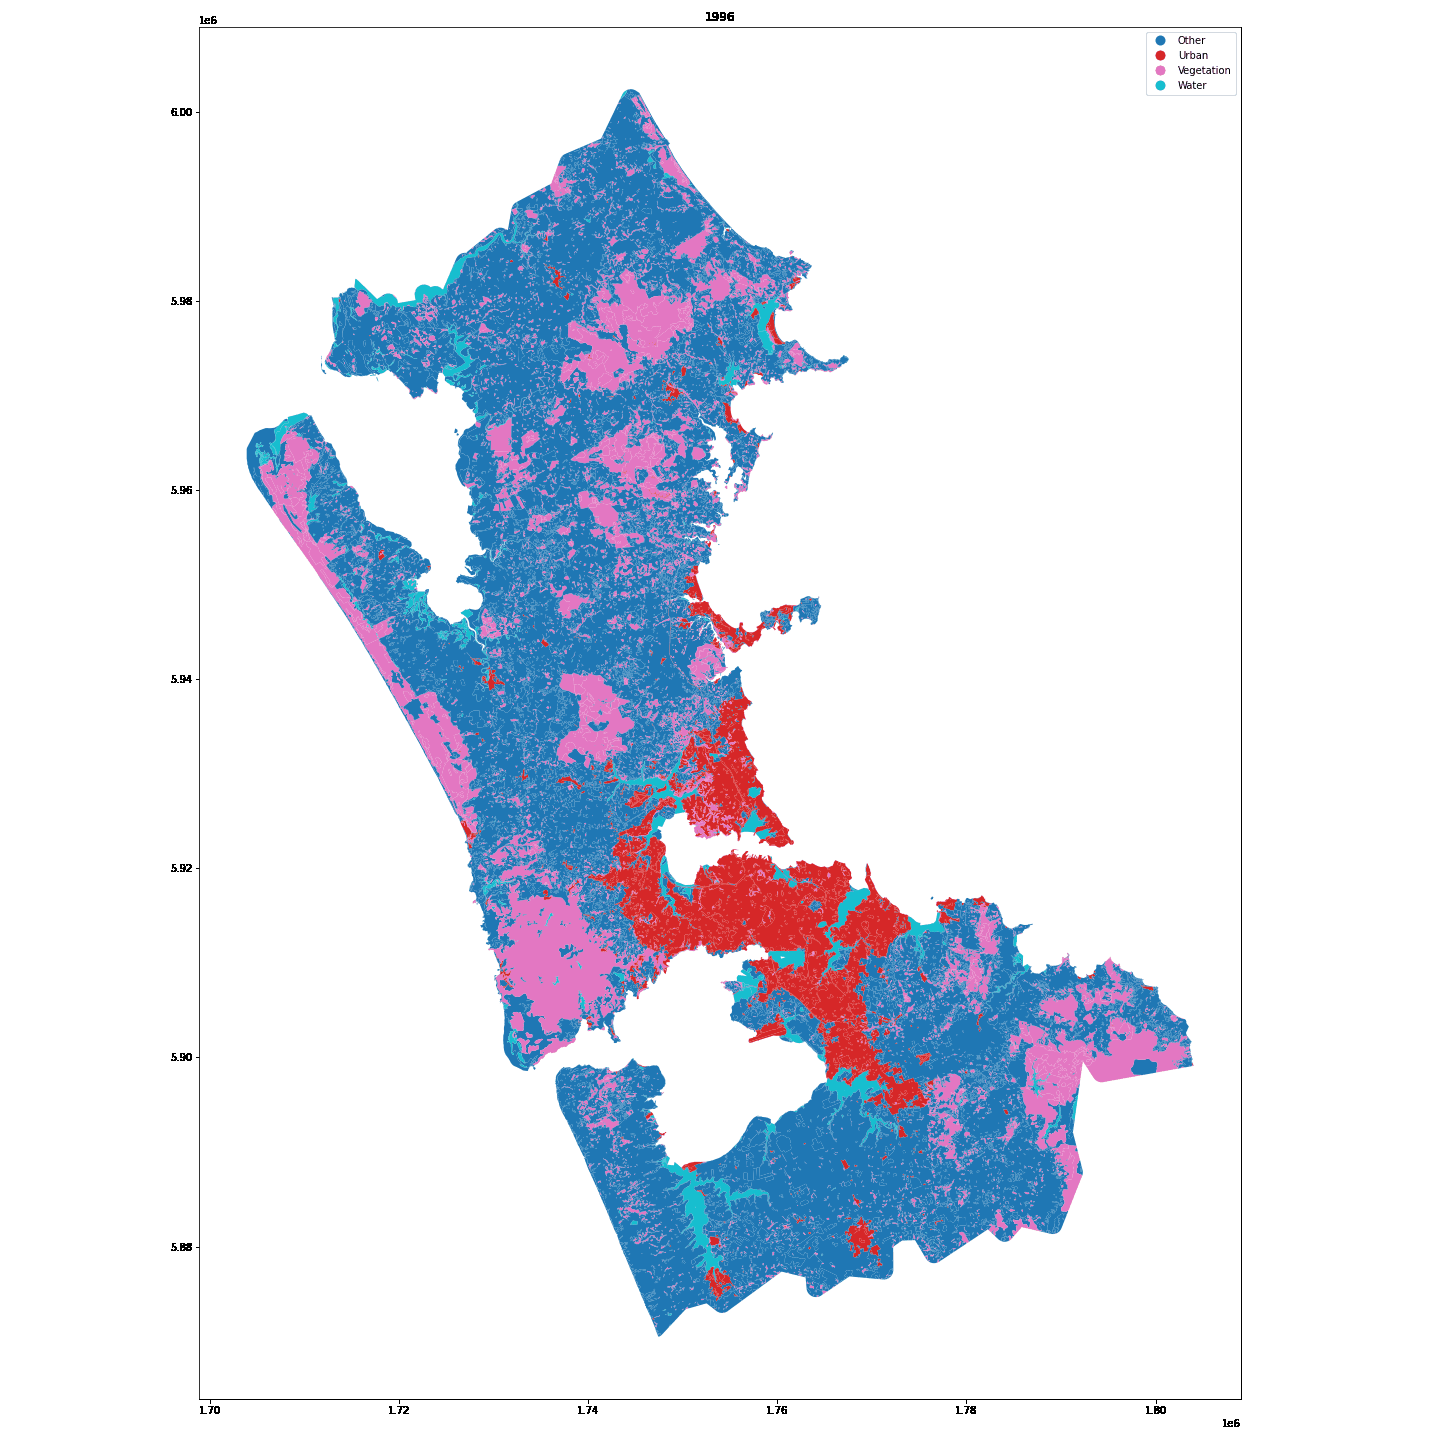

In [58]:
with open('land_use.gif','rb') as file:
    display(Image(file.read()))

In [59]:
cols = [f"Class_{year}_simplified_code" for year in years]
cols

['Class_1996_simplified_code',
 'Class_2001_simplified_code',
 'Class_2008_simplified_code',
 'Class_2012_simplified_code',
 'Class_2018_simplified_code']

In [92]:
%%time
geocube = make_geocube(
    vector_data=df,
    output_crs="epsg:2193",
    measurements=cols,
    resolution=(-100, 100)
)
geocube

CPU times: user 20.8 s, sys: 0 ns, total: 20.8 s
Wall time: 20.8 s


<xarray.Dataset>
Dimensions:                     (x: 1001, y: 1320)
Coordinates:
  * y                           (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                           (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                 int64 0
Data variables:
    Class_1996_simplified_code  (y, x) float64 nan nan nan nan ... nan nan nan
    Class_2001_simplified_code  (y, x) float64 nan nan nan nan ... nan nan nan
    Class_2008_simplified_code  (y, x) float64 nan nan nan nan ... nan nan nan
    Class_2012_simplified_code  (y, x) float64 nan nan nan nan ... nan nan nan
    Class_2018_simplified_code  (y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

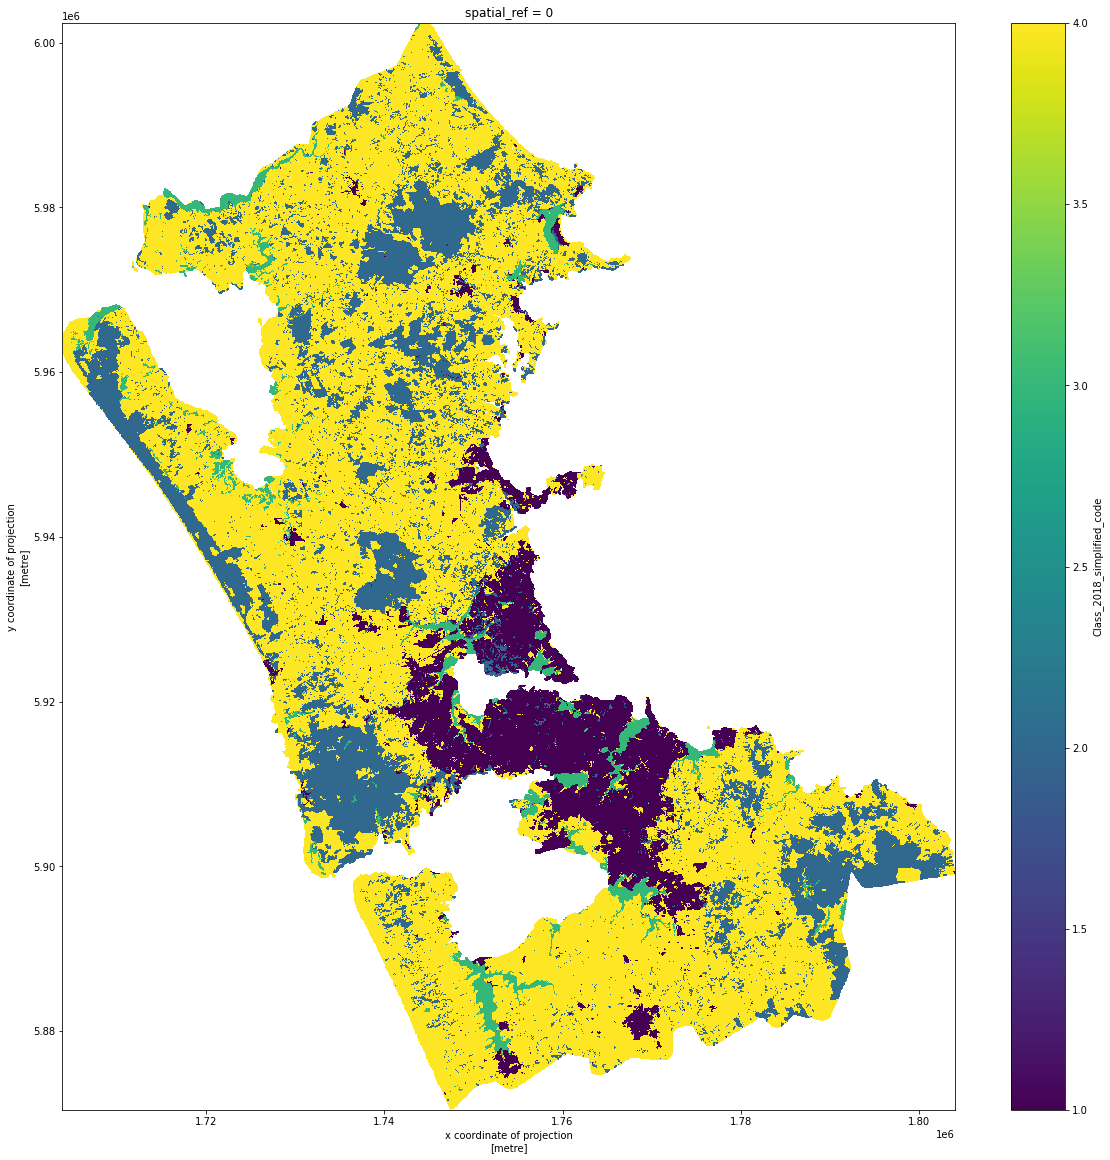

In [61]:
geocube.Class_2018_simplified_code.plot()

In [62]:
for year in years:
    print(year)
    outfile = f"output/land_use_{year}.tif"
    if not os.path.isfile(outfile):
        geocube[f"Class_{year}_simplified_code"].rio.to_raster(outfile)

1996
2001
2008
2012
2018


With land use taken care of, let's shift focus to population density

In [72]:
%%time
pop2013 = pd.read_file("input/statsnzpopulation-by-meshblock-2013-census-FGDB.zip!population-by-meshblock-2013-census.gdb")

CPU times: user 9.9 s, sys: 39.9 ms, total: 9.94 s
Wall time: 9.93 s


In [82]:
%%time
pop2013 = pd.clip(pop2013, AKL)

CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 18.7 s


In [83]:
display(pop2013.sample(5))

Meshblock MeshblockNumber  Population_Count_Usual_Resident_2013  \
14318  MB 0369502         0369502                                    51   
19620  MB 0769035         0769035                                    69   
13773  MB 0316500         0316500                                   108   
12002  MB 0210805         0210805                                    24   
11528  MB 0181107         0181107                                   201   

       Population_Count_Census_Night_2013  \
14318                                  48   
19620                                  69   
13773                                  99   
12002                                  24   
11528                                 204   

                                                geometry  
14318  POLYGON ((1750910.925 5912403.864, 1750889.796...  
19620  POLYGON ((1767213.886 5897974.890, 1767201.140...  
13773  POLYGON ((1758772.908 5924528.179, 1758787.728...  
12002  POLYGON ((1728838.610 5942857.771, 1728880.373...  
11528  POLYGON ((1751243.259 5929273.224, 1751241.056...

<AxesSubplot:ylabel='Frequency'>

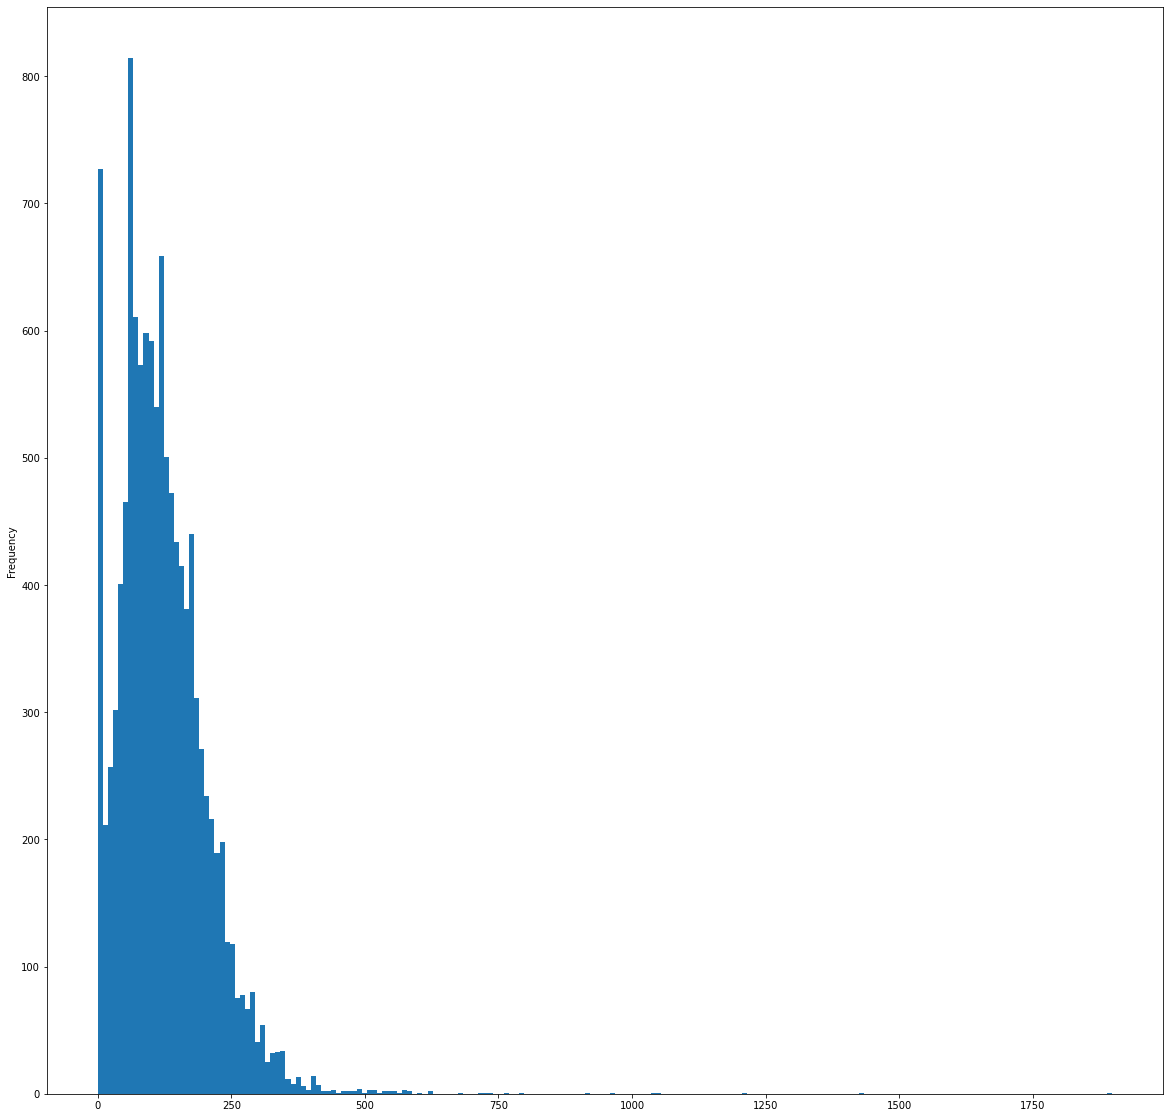

In [103]:
pop2013.Population_Count_Usual_Resident_2013.plot(kind="hist", bins=200)

In [89]:
%%time
pop2013_cube = make_geocube(
    vector_data=pop2013,
    measurements=["Population_Count_Usual_Resident_2013"],
    like=geocube # Ensures dimensions match
)
pop2013_cube

CPU times: user 3.31 s, sys: 19.9 ms, total: 3.33 s
Wall time: 3.32 s


<xarray.Dataset>
Dimensions:                               (x: 1001, y: 1320)
Coordinates:
  * y                                     (y) float64 6.002e+06 ... 5.87e+06
  * x                                     (x) float64 1.704e+06 ... 1.804e+06
    spatial_ref                           int64 0
Data variables:
    Population_Count_Usual_Resident_2013  (y, x) float64 nan nan nan ... nan nan
Attributes:
    grid_mapping:  spatial_ref

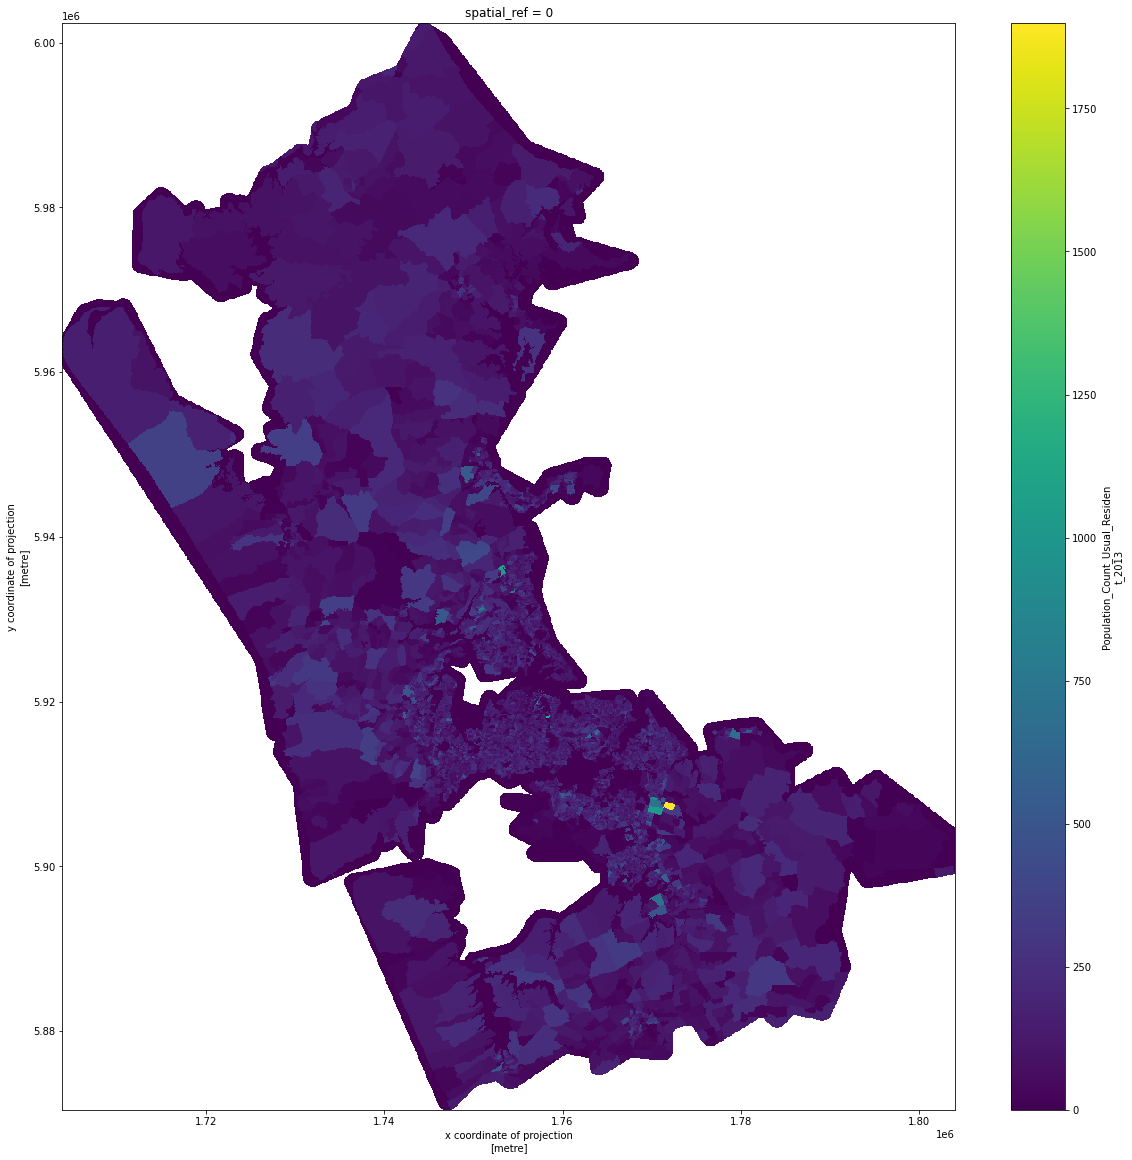

In [97]:
pop2013_cube.Population_Count_Usual_Resident_2013.plot()
outfile = "output/pop2013.tif"
if not os.path.isfile(outfile):
    pop2013_cube.Population_Count_Usual_Resident_2013.rio.to_raster()

In [106]:
%%time
pop2018 = pd.read_file("input/statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip!2018-census-electoral-population-meshblock-2020.gdb")

CPU times: user 10.5 s, sys: 19.8 ms, total: 10.5 s
Wall time: 10.5 s


In [107]:
%%time
pop2018 = pd.clip(pop2018, AKL)

CPU times: user 21.4 s, sys: 0 ns, total: 21.4 s
Wall time: 21.4 s


In [108]:
display(pop2018.sample(5))

MB2020_V2_00  General_Electoral_Population  Maori_Electoral_Population  \
13449      0240401                           114                          12   
12239      0178002                           162                        -999   
1798       0711022                           213                        -999   
52824      4011685                            60                        -999   
12448      0180878                            69                        -999   

      GED2020_V1_00 GED2020_V1_00_NAME GED2020_V1_00_NAME_ASCII MED2020_V1_00  \
13449           053           Te Atatū                 Te Atatu             3   
12239           063       Whangaparāoa             Whangaparaoa             5   
1798            004             Botany                   Botany             3   
52824           021            Māngere                  Mangere             3   
12448           010    East Coast Bays          East Coast Bays             5   

      MED2020_V1_00_NAME MED2020_V1_00_NAME_ASCII  LAND_AREA_SQ_KM  \
13449    Tāmaki Makaurau          Tamaki Makaurau         0.062642   
12239     Te Tai Tokerau           Te Tai Tokerau         4.467783   
1798     Tāmaki Makaurau          Tamaki Makaurau         0.045966   
52824    Tāmaki Makaurau          Tamaki Makaurau         0.215905   
12448     Te Tai Tokerau           Te Tai Tokerau         0.012388   

       AREA_SQ_KM  Shape_Length  \
13449    0.062642   1036.209614   
12239    4.467783  10768.947716   
1798     0.045966   1460.346370   
52824    0.215905   2406.553234   
12448    0.012388    521.436799   

                                                geometry  
13449  POLYGON ((1745958.974 5917495.060, 1746010.752...  
12239  POLYGON ((1746720.012 5942497.517, 1746718.517...  
1798   POLYGON ((1772175.317 5913319.913, 1772175.833...  
52824  POLYGON ((1762741.321 5908519.425, 1762745.900...  
12448  POLYGON ((1755010.817 5932548.328, 1755037.287...

In [109]:
pop2018.General_Electoral_Population.replace(-999, 0, inplace=True)

<AxesSubplot:ylabel='Frequency'>

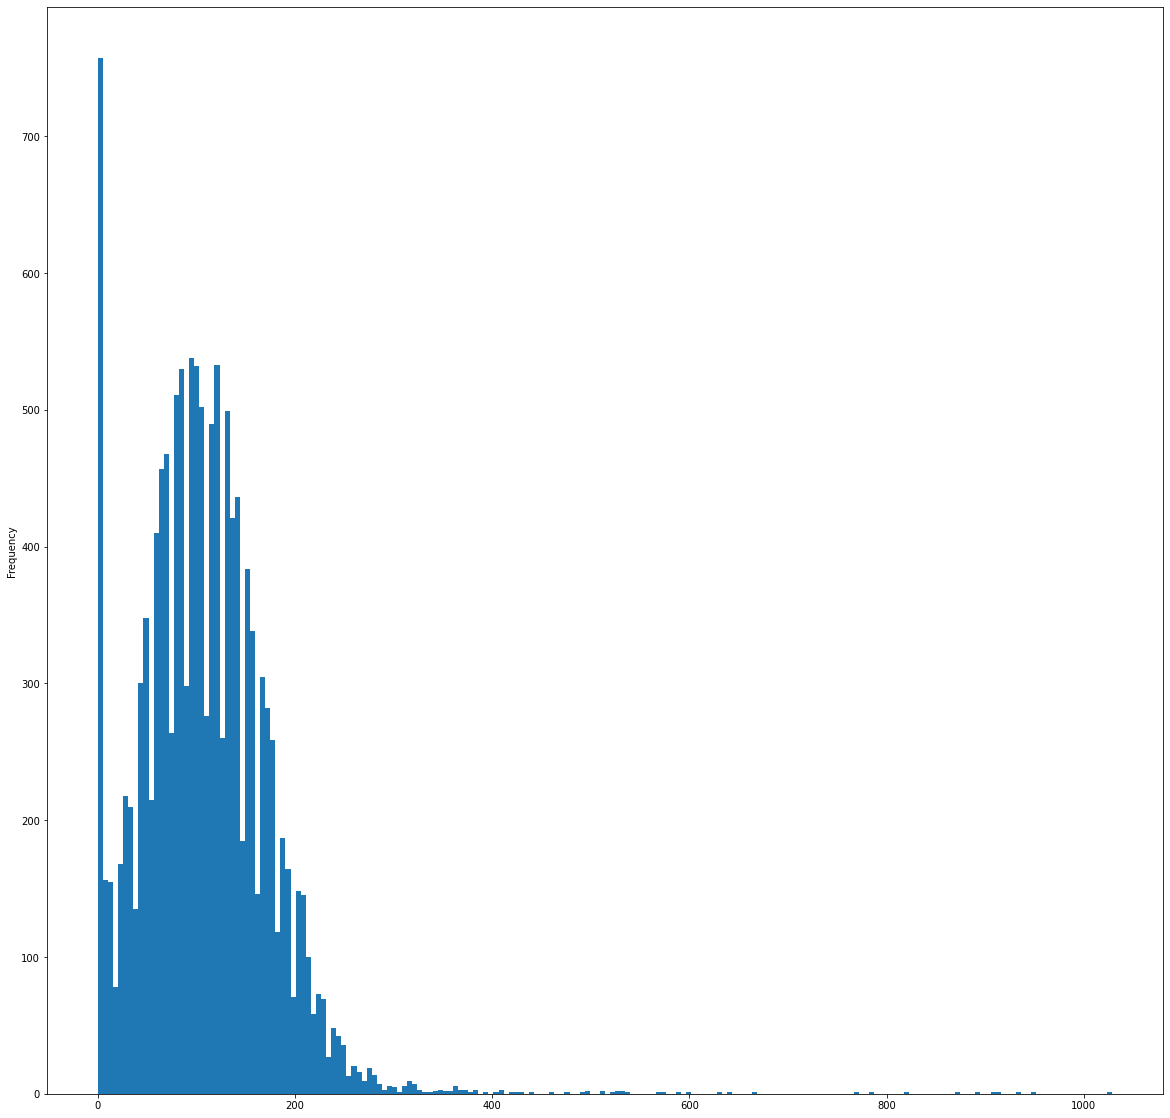

In [110]:
pop2018.General_Electoral_Population.plot(kind="hist", bins=200)

In [111]:
%%time
pop2018_cube = make_geocube(
    vector_data=pop2018,
    measurements=["General_Electoral_Population"],
    like=geocube # Ensures dimensions match
)
pop2018_cube

CPU times: user 3.13 s, sys: 10.1 ms, total: 3.14 s
Wall time: 3.14 s


<xarray.Dataset>
Dimensions:                       (x: 1001, y: 1320)
Coordinates:
  * y                             (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                             (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                   int64 0
Data variables:
    General_Electoral_Population  (y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

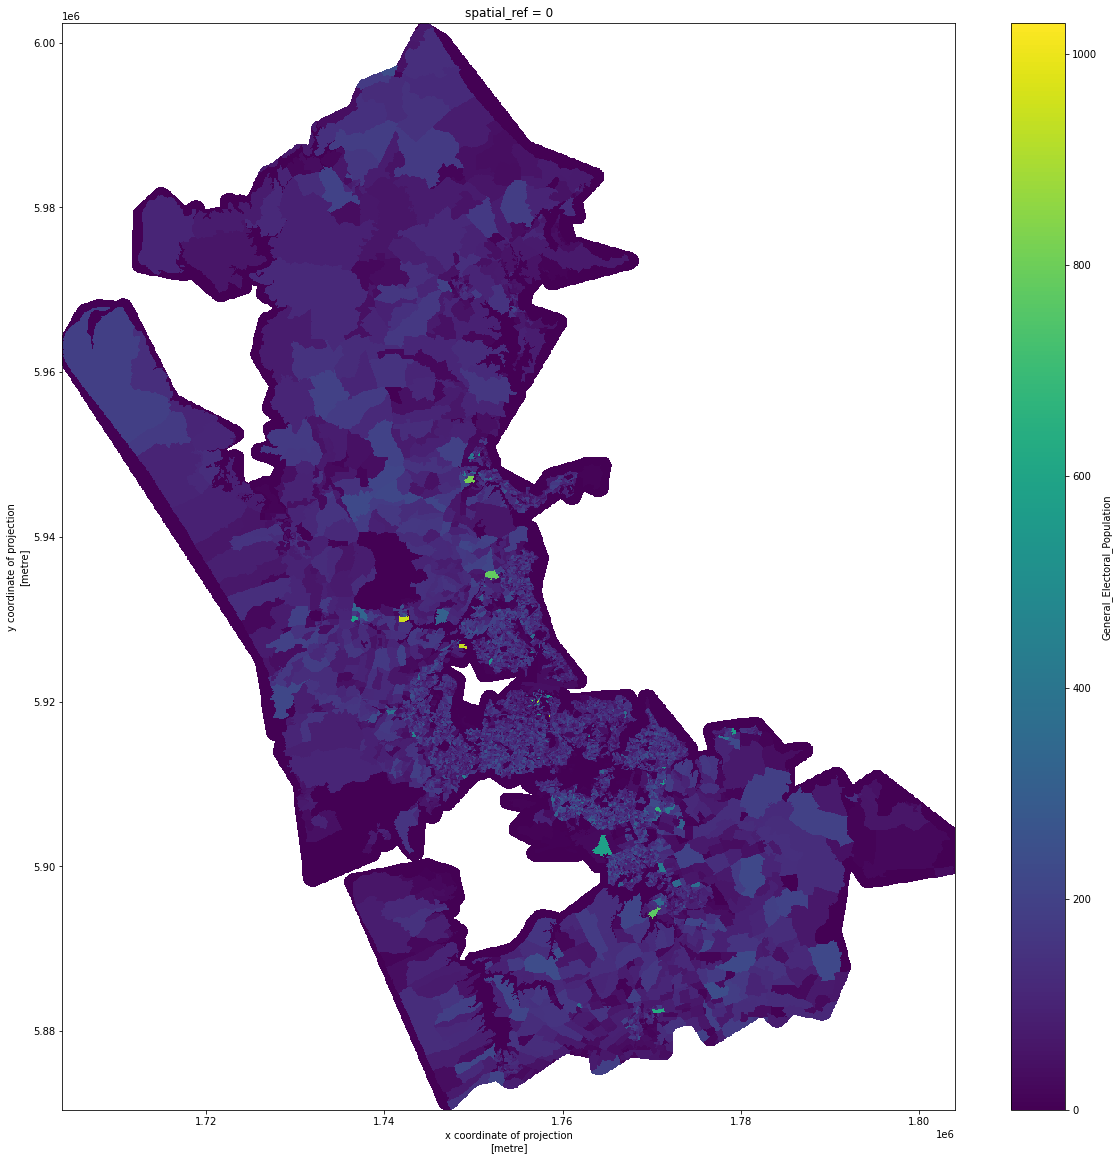

In [113]:
pop2018_cube.General_Electoral_Population.plot()
outfile = "output/pop2018.tif"
if not os.path.isfile(outfile):
    pop2018_cube.General_Electoral_Population.rio.to_raster(outfile)

In [114]:
!ls -Ggh output

total 71M
-rw-r--r-- 1 11M Apr 15 10:25 land_use_1996.tif
-rw-r--r-- 1 11M Apr 15 10:25 land_use_2001.tif
-rw-r--r-- 1 11M Apr 15 10:25 land_use_2008.tif
-rw-r--r-- 1 11M Apr 15 10:25 land_use_2012.tif
-rw-r--r-- 1 11M Apr 15 10:25 land_use_2018.tif
-rw-r--r-- 1 11M Apr 15 12:18 pop2013.tif
-rw-r--r-- 1 11M Apr 15 12:27 pop2018.tif
